In [42]:
import scanpy as sc
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


import random

In [43]:
with open("data_augmentation_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)

age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

In [44]:
df

,mean_NK,mean_CD4T,mean_CD8T,mean_B,mean_Monocyte,mean_DC,std_NK,std_CD4T,std_CD8T,std_B,std_Monocyte,std_DC
HC-519_1,4.250463,2.101322,2.585653,2.275958,4.256917,0.995282,0.219740,0.153563,0.140392,0.173827,0.270898,0.039002
HC-519_2,4.233671,2.125010,2.608677,2.249835,4.300351,0.978386,0.199198,0.149960,0.197166,0.096902,0.258499,0.085476
HC-519_3,4.266166,2.135315,2.601588,2.236187,4.253217,0.953375,0.223695,0.177710,0.155687,0.186116,0.216263,0.043319
HC-519_4,4.273546,2.080197,2.601157,2.238966,4.264690,0.994676,0.217150,0.174626,0.163971,0.186315,0.261485,0.086960
HC-519_5,4.324083,2.141739,2.615713,2.262450,4.253062,0.957692,0.228844,0.132216,0.144391,0.153588,0.193030,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...
IGTB1731_IGTB1731_6,6.563656,3.568826,4.199865,3.961308,5.613795,1.637987,0.244200,0.189973,0.159651,0.136891,0.203070,0.122695
IGTB1731_IGTB1731_7,6.596188,3.580332,4.289095,3.913684,5.553950,1.640019,0.258587,0.130674,0.185953,0.124926,0.246717,0.078834
IGTB1731_IGTB1731_8,6.592616,3.584274,4.251048,3.960035,5.568194,1.599903,0.241156,0.173601,0.174416,0.155811,0.245737,0.078717
IGTB1731_IGTB1731_9,6.570584,3.537206,4.293931,3.941113,5.570133,1.641331,0.227840,0.175775,0.160713,0.160330,0.211768,0.060764


In [45]:
def train_test_split(df, age, random_size):
    all_numbers = set(range(93))
    random_numbers = random.sample(sorted(all_numbers), random_size)
    all_numbers -= set(random_numbers)  # 從所有數字中移除已經選取的數字
    
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype='int')
    for i in random_numbers:
        X_test = pd.concat([X_test, df.iloc[i*10:i*10+10]])
        y_test = pd.concat([y_test, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
        
    
    random_validation = random.sample(sorted(all_numbers), 10)
    
    X_validation = pd.DataFrame()
    y_validation = pd.Series(dtype='int')
    for i in random_validation:
        X_validation = pd.concat([X_validation, df.iloc[i*10:i*10+10]])
        y_validation = pd.concat([y_validation, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
    
    X_train = df
    y_train = age
    
    
    return X_train, X_test, y_train, y_test, X_validation, y_validation


def XGBR(X_train, X_test, y_train, y_test, n_estimators=65, max_depth=4, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8):
    # n_jobs=-1處理器全開
    xgbrModel = xgb.XGBRegressor(n_estimators = n_estimators, n_jobs=-1, max_depth = max_depth,
                                 colsample_bytree = colsample_bytree, gamma = gamma, min_child_weight = min_child_weight,
                                subsample = subsample, eval_metric="rmse")  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model with early stopping
    eval_set = [(X_test, y_test)]
    xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',xgbrModel.score(X_train,y_train))
    print('Test Set score: ',xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')
    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線
    plt.xlabel('Actual Ages',fontsize = 14)
    plt.ylabel('Predicted Ages',fontsize = 14)
    plt.title('Actual vs Predicted Ages',fontsize = 16)
    plt.show()


    print('特徵重要程度: ',xgbrModel.feature_importances_)
    
def RandomForestRegression(X_train, X_test, y_train, y_test, n_estimators=10):
    # n_jobs=-1處理器全開
    RFR = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)# , random_state=0
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)
    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(RFR, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model
    RFR.fit(X_train, y_train)

    y_pred = RFR.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',RFR.score(X_train,y_train))
    print('Test Set score: ',RFR.score(X_test,y_test))

    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')

    plt.scatter(y_test, y_pred, s=10, label='True')
    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線
    plt.xlabel('Actual Ages',fontsize = 14)
    plt.ylabel('Predicted Ages',fontsize = 14)
    plt.title('Actual vs Predicted Ages',fontsize = 16)
    plt.show()
    
    
    print('特徵重要程度: ',RFR.feature_importances_)
    #print('樹的深度: ',RFR.get_depth)

In [46]:
X_train, X_test, y_train, y_test, X_validation, y_validation = train_test_split(df, age, 30)

Cross-validation scores:  [0.7833312  0.71969269 0.77042515 0.70461934 0.81363801 0.8723245
 0.80213275 0.62823801 0.80906289 0.75310978]
Mean Squared Error (MSE): 19.256056874197746
Mean Absolute Error (MAE): 3.3670058822631836
Train Set score:  0.8501466662093529
Test Set score:  0.8610896826965536
Pearson correlation: 0.9347368817612282


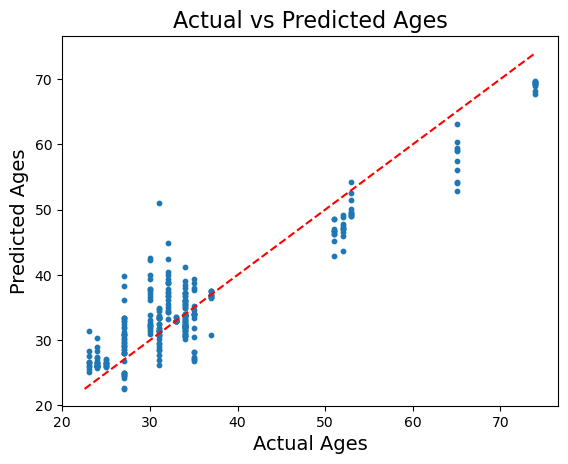

特徵重要程度:  [0.09056703 0.1326077  0.18510775 0.21787764 0.11124714 0.14690028
 0.         0.02327307 0.02073984 0.01145743 0.03271106 0.02751094]


In [47]:
XGBR(X_train, X_test, y_train, y_test, n_estimators=45, max_depth=2, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8)

Cross-validation scores:  [0.91576989 0.91780152 0.92903494 0.93333583 0.88530706 0.77862463
 0.95417669 0.93628676 0.96188591 0.88754632]
Mean Squared Error (MSE): 2.8007
Mean Absolute Error (MAE): 0.6923333333333332
Train Set score:  0.9880866312776732
Test Set score:  0.979796168643796
Pearson correlation: 0.9905678726276181


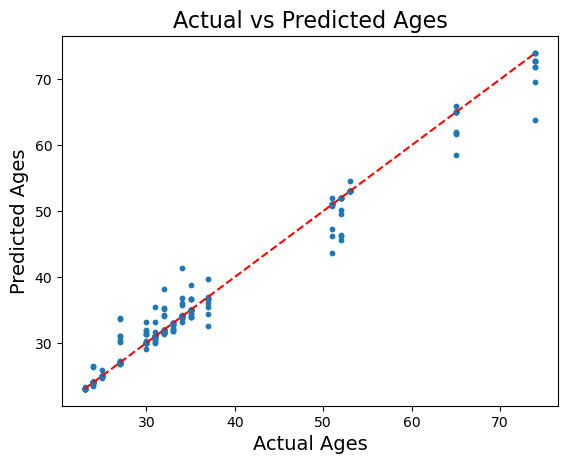

特徵重要程度:  [0.14489262 0.14375748 0.16268934 0.27814566 0.10803769 0.13022488
 0.00691466 0.00797819 0.00523402 0.00202651 0.00778846 0.00231049]


In [48]:
RandomForestRegression(X_train, X_test, y_train, y_test, n_estimators=10)

# Model + Validation
     max_depth = 4

Cross-validation scores:  [0.90710196 0.93586133 0.92544113 0.86192163 0.94117682 0.86517133
 0.93463006 0.93705827 0.90721058 0.9399807 ]
Mean Squared Error (MSE): 1.3858260715190773
Mean Absolute Error (MAE): 0.848293883005778
Train Set score:  0.9909431234408937
Test Set score:  0.9900028577719848
Pearson correlation: 0.9951588263853518


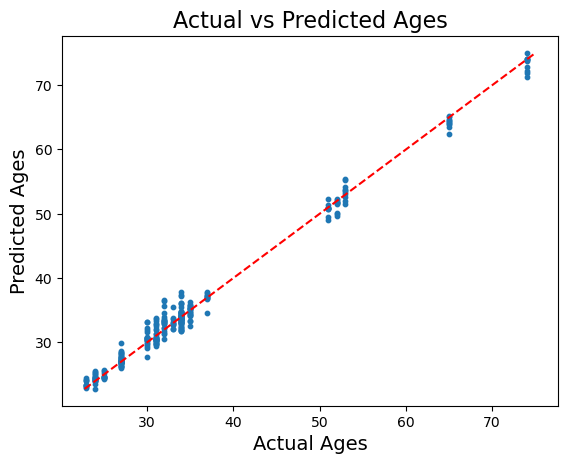

特徵重要程度:  [0.14566852 0.17117806 0.16016327 0.26875195 0.08497985 0.12577462
 0.00672425 0.00850266 0.01144748 0.00584799 0.00665445 0.004307  ]


In [49]:
# n_jobs=-1處理器全開
xgbrModel = xgb.XGBRegressor(n_estimators = 45, n_jobs=-1, max_depth = 4,
                            colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,
                            subsample = 0.8, eval_metric="rmse")  
# 創建k折交叉驗證對象
kf = KFold(n_splits=10, shuffle=True)

# 進行 k-fold cross-validation，例如 k=10
scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
print('Cross-validation scores: ', scores)

# train model with early stopping
eval_set = [(X_test, y_test)]
xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = xgbrModel.predict(X_test)

# 計算均方誤差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 預測成功的比例
print('Train Set score: ',xgbrModel.score(X_train,y_train))
print('Test Set score: ',xgbrModel.score(X_test,y_test))
# 計算皮爾森相關係數
corr, _ = pearsonr(y_test, y_pred)
print(f'Pearson correlation: {corr}')
plt.scatter(y_test, y_pred, s=10, label='True')

# 繪製對角線
min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線


plt.xlabel('Actual Ages',fontsize = 14)
plt.ylabel('Predicted Ages',fontsize = 14)
plt.title('Actual vs Predicted Ages',fontsize = 16)
plt.show()


print('特徵重要程度: ',xgbrModel.feature_importances_)

In [50]:
set(y_validation)

{21, 26, 27, 28, 33, 35, 53}

Mean Squared Error (MSE): 1.087828007015669
Mean Absolute Error (MAE): 0.7854426002502441
Validataion Set score:  0.9834777034171375
Pearson correlation: 0.9918541694848846


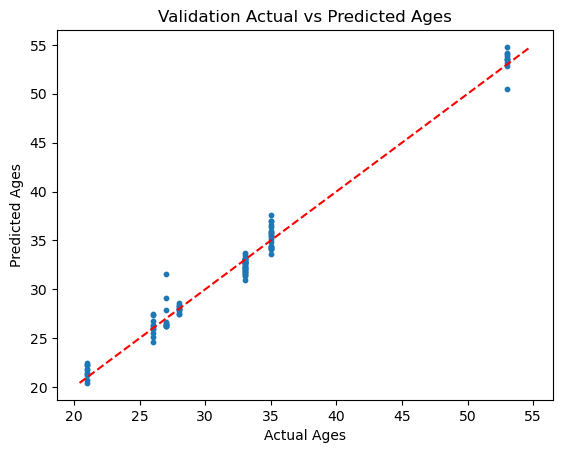

In [51]:
y_pred_valid = xgbrModel.predict(X_validation)

# 計算均方誤差（Mean Squared Error, MSE）
mse_valid = mean_squared_error(y_validation, y_pred_valid)
print(f'Mean Squared Error (MSE): {mse_valid}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae_valid = mean_absolute_error(y_validation, y_pred_valid)
print(f'Mean Absolute Error (MAE): {mae_valid}')

print('Validataion Set score: ',xgbrModel.score(X_validation,y_validation))

# 計算皮爾森相關係數
corr_valid, _ = pearsonr(y_validation, y_pred_valid)
print(f'Pearson correlation: {corr_valid}')
plt.scatter(y_validation, y_pred_valid, s=10, label='True')

# 繪製對角線
min_val = np.min([np.min(y_validation), np.min(y_pred_valid)])  # 找到最小值
max_val = np.max([np.max(y_validation), np.max(y_pred_valid)])  # 找到最大值
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.title('Validation Actual vs Predicted Ages')
plt.show()

# SLE 

In [52]:
#with open("data_augmentation_GSE174188_SLE.csv", 'r') as file:
with open("mean_and_stdev_GSE174188_SLE.csv", 'r') as file:
    df_SLE = pd.read_csv(file, index_col = 0)

age_SLE = df_SLE["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df_SLE = df_SLE.drop(columns = "age", axis = 1)

In [53]:
SLE_pred = xgbrModel.predict(df_SLE)

# 計算均方誤差（Mean Squared Error, MSE）
mse_SLE = mean_squared_error(age_SLE, SLE_pred)
print(f'Mean Squared Error (MSE): {mse_SLE}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae_SLE = mean_absolute_error(age_SLE, SLE_pred)
print(f'Mean Absolute Error (MAE): {mae_SLE}')

print('Validataion Set score: ',xgbrModel.score(df_SLE,age_SLE))

Mean Squared Error (MSE): 427.86572812311647
Mean Absolute Error (MAE): 16.803246077670845
Validataion Set score:  -1.0015180266649262


In [54]:
for i in range(len(age_SLE)):
    print(f"Actual: {age_SLE[i]} \tPredict: {SLE_pred[i]}")

Actual: 20 	Predict: 70.348876953125
Actual: 21 	Predict: 34.74736022949219
Actual: 21 	Predict: 57.61215591430664
Actual: 21 	Predict: 53.61951446533203
Actual: 22 	Predict: 61.53514862060547
Actual: 23 	Predict: 54.5904541015625
Actual: 24 	Predict: 58.77021789550781
Actual: 25 	Predict: 35.27519989013672
Actual: 26 	Predict: 67.19308471679688
Actual: 27 	Predict: 53.05581283569336
Actual: 27 	Predict: 65.31938171386719
Actual: 27 	Predict: 47.07225036621094
Actual: 27 	Predict: 57.212310791015625
Actual: 27 	Predict: 56.426692962646484
Actual: 27 	Predict: 52.88664627075195
Actual: 28 	Predict: 50.7337532043457
Actual: 28 	Predict: 56.643524169921875
Actual: 29 	Predict: 64.13874816894531
Actual: 29 	Predict: 64.52687072753906
Actual: 29 	Predict: 32.41779708862305
Actual: 30 	Predict: 43.36528015136719
Actual: 31 	Predict: 33.70288848876953
Actual: 31 	Predict: 64.7453384399414
Actual: 31 	Predict: 56.574092864990234
Actual: 31 	Predict: 71.2882308959961
Actual: 32 	Predict: 60.075

Pearson correlation: 0.17178400598577423


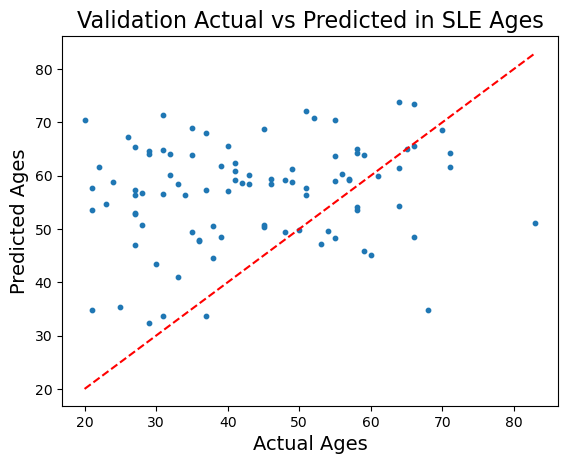

In [55]:
# 計算皮爾森相關係數
corr_SLE, _ = pearsonr(age_SLE, SLE_pred)
print(f'Pearson correlation: {corr_SLE}')
plt.scatter(age_SLE, SLE_pred, s=10, label='True')

# 繪製對角線
min_val = np.min([np.min(age_SLE), np.min(SLE_pred)])  # 找到最小值
max_val = np.max([np.max(age_SLE), np.max(SLE_pred)])  # 找到最大值
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線


plt.xlabel('Actual Ages',fontsize=14)
plt.ylabel('Predicted Ages',fontsize=14)
plt.title('Validation Actual vs Predicted in SLE Ages',fontsize=16)
plt.show()

# XGBR intersection

In [97]:
with open("data_augmentation_GSE174188_intersection.csv", 'r') as file:
    df_intersection = pd.read_csv(file, index_col = 0)

age_intersection = df_intersection["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df_intersection = df_intersection.drop(columns = "age", axis = 1)

In [93]:
with open("mean_and_stdev_GSE165080.csv", 'r') as file:
    df_merge_data = pd.read_csv(file, index_col = 0)

age_merge_data = df_merge_data["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df_merge_data = df_merge_data.drop(columns = "age", axis = 1)

In [98]:
X_train, X_test, y_train, y_test, X_validation, y_validation = train_test_split(df_intersection, age_intersection, 30)

Cross-validation scores:  [0.85794681 0.91793415 0.89889631 0.86773202 0.92580511 0.93068648
 0.89403099 0.9498734  0.81879936 0.94269481]
Mean Squared Error (MSE): 2.632737325296463
Mean Absolute Error (MAE): 1.160859572092692
Train Set score:  0.9877122986627573
Test Set score:  0.9883263854211
Pearson correlation: 0.9951904316606524


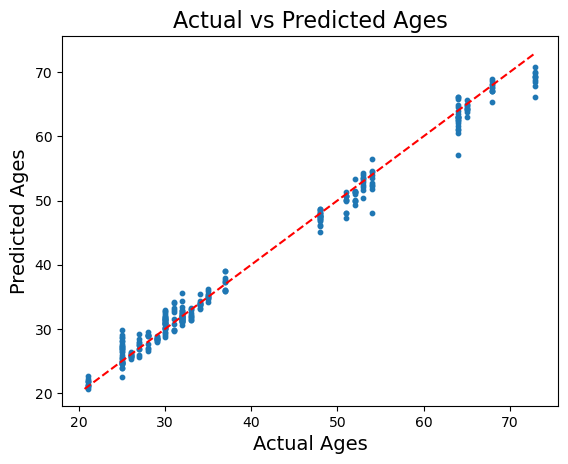

特徵重要程度:  [0.10841206 0.14412127 0.19102801 0.2393824  0.1445611  0.10332072
 0.01499295 0.01135381 0.00871892 0.01418235 0.00977571 0.01015069]


In [99]:
# n_jobs=-1處理器全開
xgbrModel = xgb.XGBRegressor(n_estimators = 45, n_jobs=-1, max_depth = 4,
                            colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,
                            subsample = 0.8, eval_metric="rmse")  
# 創建k折交叉驗證對象
kf = KFold(n_splits=10, shuffle=True)

# 進行 k-fold cross-validation，例如 k=10
scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
print('Cross-validation scores: ', scores)

# train model with early stopping
eval_set = [(X_test, y_test)]
xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = xgbrModel.predict(X_test)

# 計算均方誤差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 預測成功的比例
print('Train Set score: ',xgbrModel.score(X_train,y_train))
print('Test Set score: ',xgbrModel.score(X_test,y_test))
# 計算皮爾森相關係數
corr, _ = pearsonr(y_test, y_pred)
print(f'Pearson correlation: {corr}')
plt.scatter(y_test, y_pred, s=10, label='True')

# 繪製對角線
min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線


plt.xlabel('Actual Ages',fontsize = 14)
plt.ylabel('Predicted Ages',fontsize = 14)
plt.title('Actual vs Predicted Ages',fontsize = 16)
plt.show()


print('特徵重要程度: ',xgbrModel.feature_importances_)

Mean Squared Error (MSE): 836.5951166158986
Mean Absolute Error (MAE): 27.0839580189098
Validataion Set score:  -13.586168459729645
Pearson correlation: 0.06968403953152291


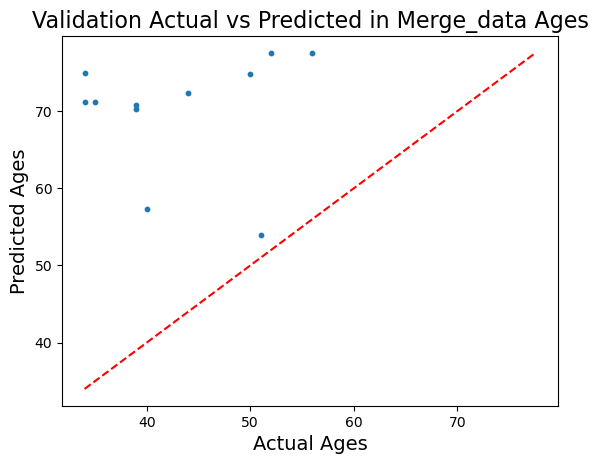

In [100]:
merge_pred = xgbrModel.predict(df_merge_data)

# 計算均方誤差（Mean Squared Error, MSE）
mse_merge = mean_squared_error(age_merge_data, merge_pred)
print(f'Mean Squared Error (MSE): {mse_merge}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae_merge = mean_absolute_error(age_merge_data, merge_pred)
print(f'Mean Absolute Error (MAE): {mae_merge}')

print('Validataion Set score: ',xgbrModel.score(df_merge_data,age_merge_data))
# 計算皮爾森相關係數
corr_merge_data, _ = pearsonr(age_merge_data, merge_pred)
print(f'Pearson correlation: {corr_merge_data}')
plt.scatter(age_merge_data, merge_pred, s=10, label='True')

# 繪製對角線
min_val = np.min([np.min(age_merge_data), np.min(merge_pred)])  # 找到最小值
max_val = np.max([np.max(age_merge_data), np.max(merge_pred)])  # 找到最大值
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線


plt.xlabel('Actual Ages',fontsize=14)
plt.ylabel('Predicted Ages',fontsize=14)
plt.title('Validation Actual vs Predicted in Merge_data Ages',fontsize=16)
plt.show()